## LipSDP (Lipschitz Constant Estimation via Semi-Definite Programming) using CVXPY

Here, we are asked to find an estimation of the Lipschitz constant for a single layer Neural Network with the ReLU Activation Function. We provide estimates using two different functions and compare the two. While the first does it by computing the **Spectral Norm** of the weight matrices and multiplying them to obtain the lipschitz constant, the second one does it using the **DCP System of CVXPY by deploying LipSDP**.

In [1]:
# importing necessary libraries
import cvxpy as cp
import numpy as np

Here, we consider a single layer Neural Network define by the function $f(X)=W^{1} {\phi}(W^{0}x + b^{0}) + b^{1}$ where ${\phi}$ is the ReLU Activation Function

the function: *lipschitz_constant_1* computes the lipschitz constant simply by computing the **Spectral Norm** of the weights since it is a single layer neural network 

In [2]:
def lipschitz_constant_1(W0, W1):
    # computes 2-norm also known as Spectral norm
    norm_W0 = np.linalg.norm(W0, ord=2)
    norm_W1 = np.linalg.norm(W1, ord=2)
    lipschitz_constant = norm_W0 * norm_W1
    return lipschitz_constant

In [3]:
# test case 1
# weight matrices
W0 = np.array([[1, 0],[0, 1]]) 
W1 = np.array([[1, 0], [0, 1]])

lipschitz_constant = lipschitz_constant_1(W0, W1)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 1.0


In [4]:
# test case 2
# weight matrices
W0 = np.array([[62, 10],[-19, 10]]) 
W1 = np.array([[1, 0],[0, 1]])  


lipschitz_constant = lipschitz_constant_1(W0, W1)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 65.19698634456758


In [5]:
# test case 3
# weight matrices
W0 = np.array([[1020, 35783],[3, 371]]) 
W1 = np.array([[1, 0],[0, 1]])

lipschitz_constant = lipschitz_constant_1(W0, W1)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 35799.45644372084


In [6]:
# test case 4
# weight matrices
W0 = np.array([[78, 10, 100],[-259, 23, 0], [94, 60, 11]]) 
W1 = np.array([[3, 2, 1],[-2, 2, 0], [4, 0, 1]])

lipschitz_constant = lipschitz_constant_1(W0, W1)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 1603.8124136552176


In [7]:
# test case 5
# weight matrices
W0 = np.array([[1, 0, 0, 0],[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
W1 = np.array([[1, 0, 0, 0],[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

lipschitz_constant = lipschitz_constant_1(W0, W1)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 1.0


the function: *lipschitz_constant_2* uses CVXPY which follows **Disciplined Convex Programming (DCP)** system to solve the given convex optimization problem

### We use the following theorem to formulate the Semi Definite Program: 

Details of the Theorem can be found in this paper: https://proceedings.neurips.cc/paper/2019/hash/95e1533eb1b20a97777749fb94fdb944-Abstract.html

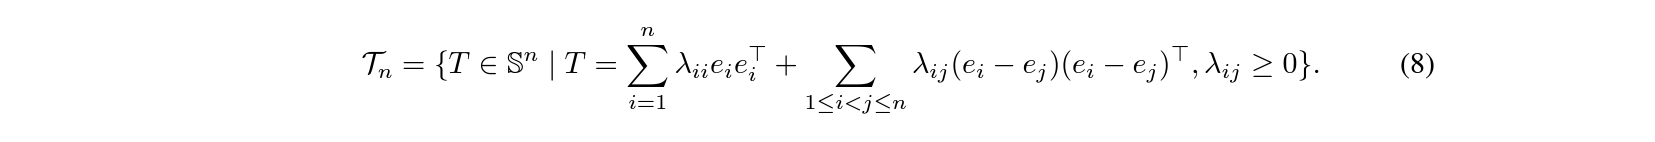

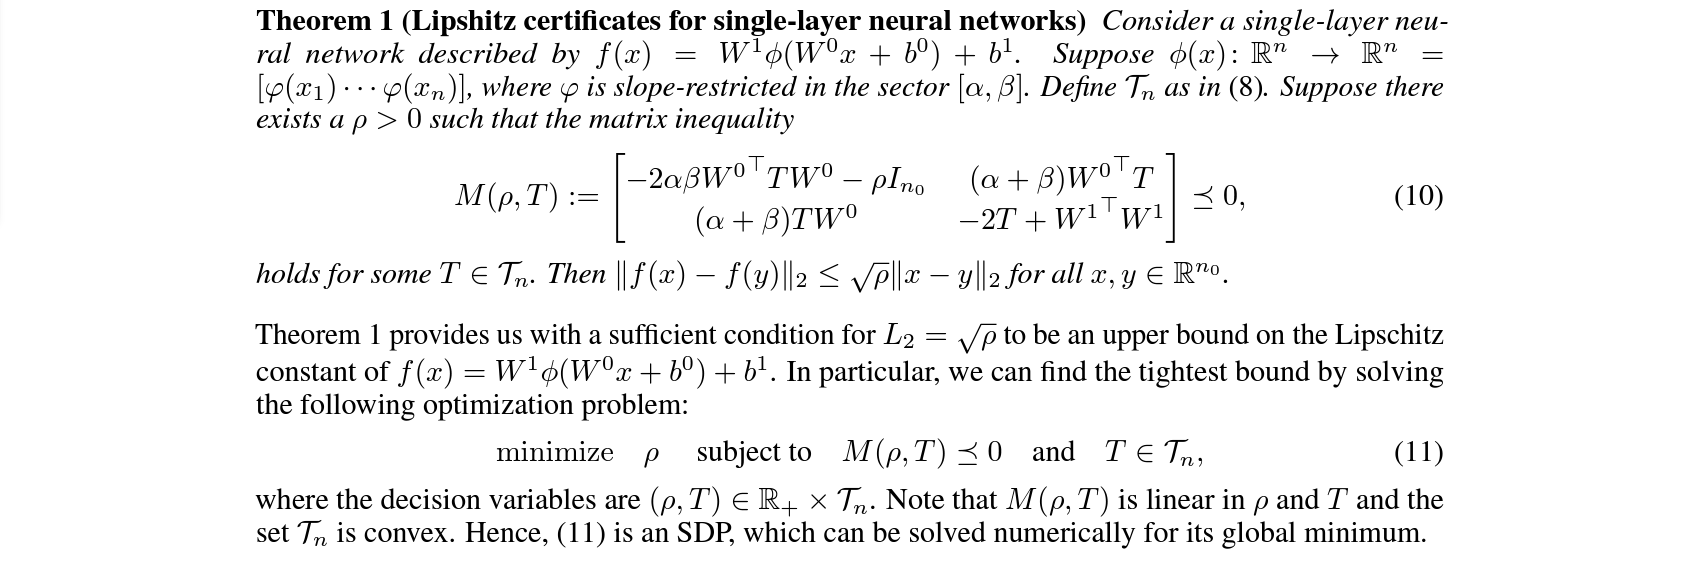

In [15]:
def lipschitz_constant_2(W0, W1, alpha, beta):
    
    n = W0.shape[1]  # number of columns in W0 (hidden layer size)
    m = W1.shape[0]  # number of rows in W1 (number of neurons in the hidden layer)

    # defining the decision variable
    rho = cp.Variable(nonneg=True)
    diag_entries = cp.Variable(m, nonneg=True)
    Tm = cp.diag(diag_entries)

    # defining the matrix inequality M(ρ, Tm)
    M_upper_left = -2 * alpha * beta * (W0.T @ Tm @ W0) - rho * np.eye(W0.shape[0])
    M_upper_right = (alpha + beta) * (W0.T @ Tm)
    M_lower_left = (alpha + beta) * (Tm @ W0)
    M_lower_right = -2 * Tm + W1.T @ W1

    # constructing the block matrix M(ρ, Tm)
    M = cp.bmat([
        [M_upper_left, M_upper_right],
        [M_lower_left, M_lower_right]
    ])

    # defining the constraints
    # M(ρ, Tm) is negative semidefinite and Tm has only positive diagonal entries
    constraints = [M << 0, diag_entries >= 0]

    # defining the objective function
    objective = cp.Minimize(rho)

    # defining the problem
    problem = cp.Problem(objective, constraints)
    
    # solving the problem
    problem.solve(solver=cp.SCS) # using the Splitting Conic Solver
    
    if problem.status not in ["infeasible", "unbounded"]:
        lipschitz_constant = np.sqrt(rho.value)
        return lipschitz_constant
    else:
        return None


**Note:** As we can see in the above theorem and function, the lipschitz constant does not depend on $b^{0}$ and $b^{1}$. 

We set the values of alpha and beta considering the activation function is slope restricted between [${\alpha}, {\beta}$].


In [16]:
alpha = 0.0  # setting alpha = 0
beta = 1.0   # setting beta = 1

In [17]:
# test case 1
# weight matrices
W0 = np.array([[1, 0],[0, 1]]) 
W1 = np.array([[1, 0], [0, 1]])

lipschitz_constant = lipschitz_constant_2(W0, W1, alpha, beta)
print("Lipschitz constant:", lipschitz_constant)

Lipschitz constant: 1.0000025938862902


In [18]:
# test case 2
# weight matrices
W0 = np.array([[62, 10],[-19, 10]]) 
W1 = np.array([[1, 0],[0, 1]])  

lipschitz_constant = lipschitz_constant_2(W0, W1, alpha, beta)
print("Lipschitz constant:", lipschitz_constant)

Lipschitz constant: 64.61611223542766


In [19]:
# test case 3
# weight matrices
W0 = np.array([[1020, 35783],[3, 371]]) 
W1 = np.array([[1, 0],[0, 1]]) 

lipschitz_constant = lipschitz_constant_2(W0, W1, alpha, beta)
print("Lipschitz constant:", lipschitz_constant)

Lipschitz constant: 554.6152199638269


In [20]:
# test case 4
# weight matrices
W0 = np.array([[78, 10, 100],[-259, 23, 0], [94, 60, 11]]) 
W1 = np.array([[3, 2, 1],[-2, 2, 0], [4, 0, 1]]) 

lipschitz_constant = lipschitz_constant_2(W0, W1, alpha, beta)
print("Lipschitz constant:", lipschitz_constant)

Lipschitz constant: 716.2285144002412


In [21]:
# test case 5
# weight matrices
W0 = np.array([[1, 0, 0, 0],[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
W1 = np.array([[1, 0, 0, 0],[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

lipschitz_constant = lipschitz_constant_2(W0, W1, alpha, beta)
print("Lipschitz constant:", lipschitz_constant)

Lipschitz constant: 1.0000004858875091
